In [1]:
# Section 2 Data Explore
# QCHE996 / QIJIN CHEN

In [2]:
############################# 2.3 Data Exploration

In [3]:
# Read in files, using pandas (As Spark Frame are hard to dealing with this part)
import pandas

filePath = "./stoke_dataset.csv"
org_frame = pandas.read_csv(filePath)

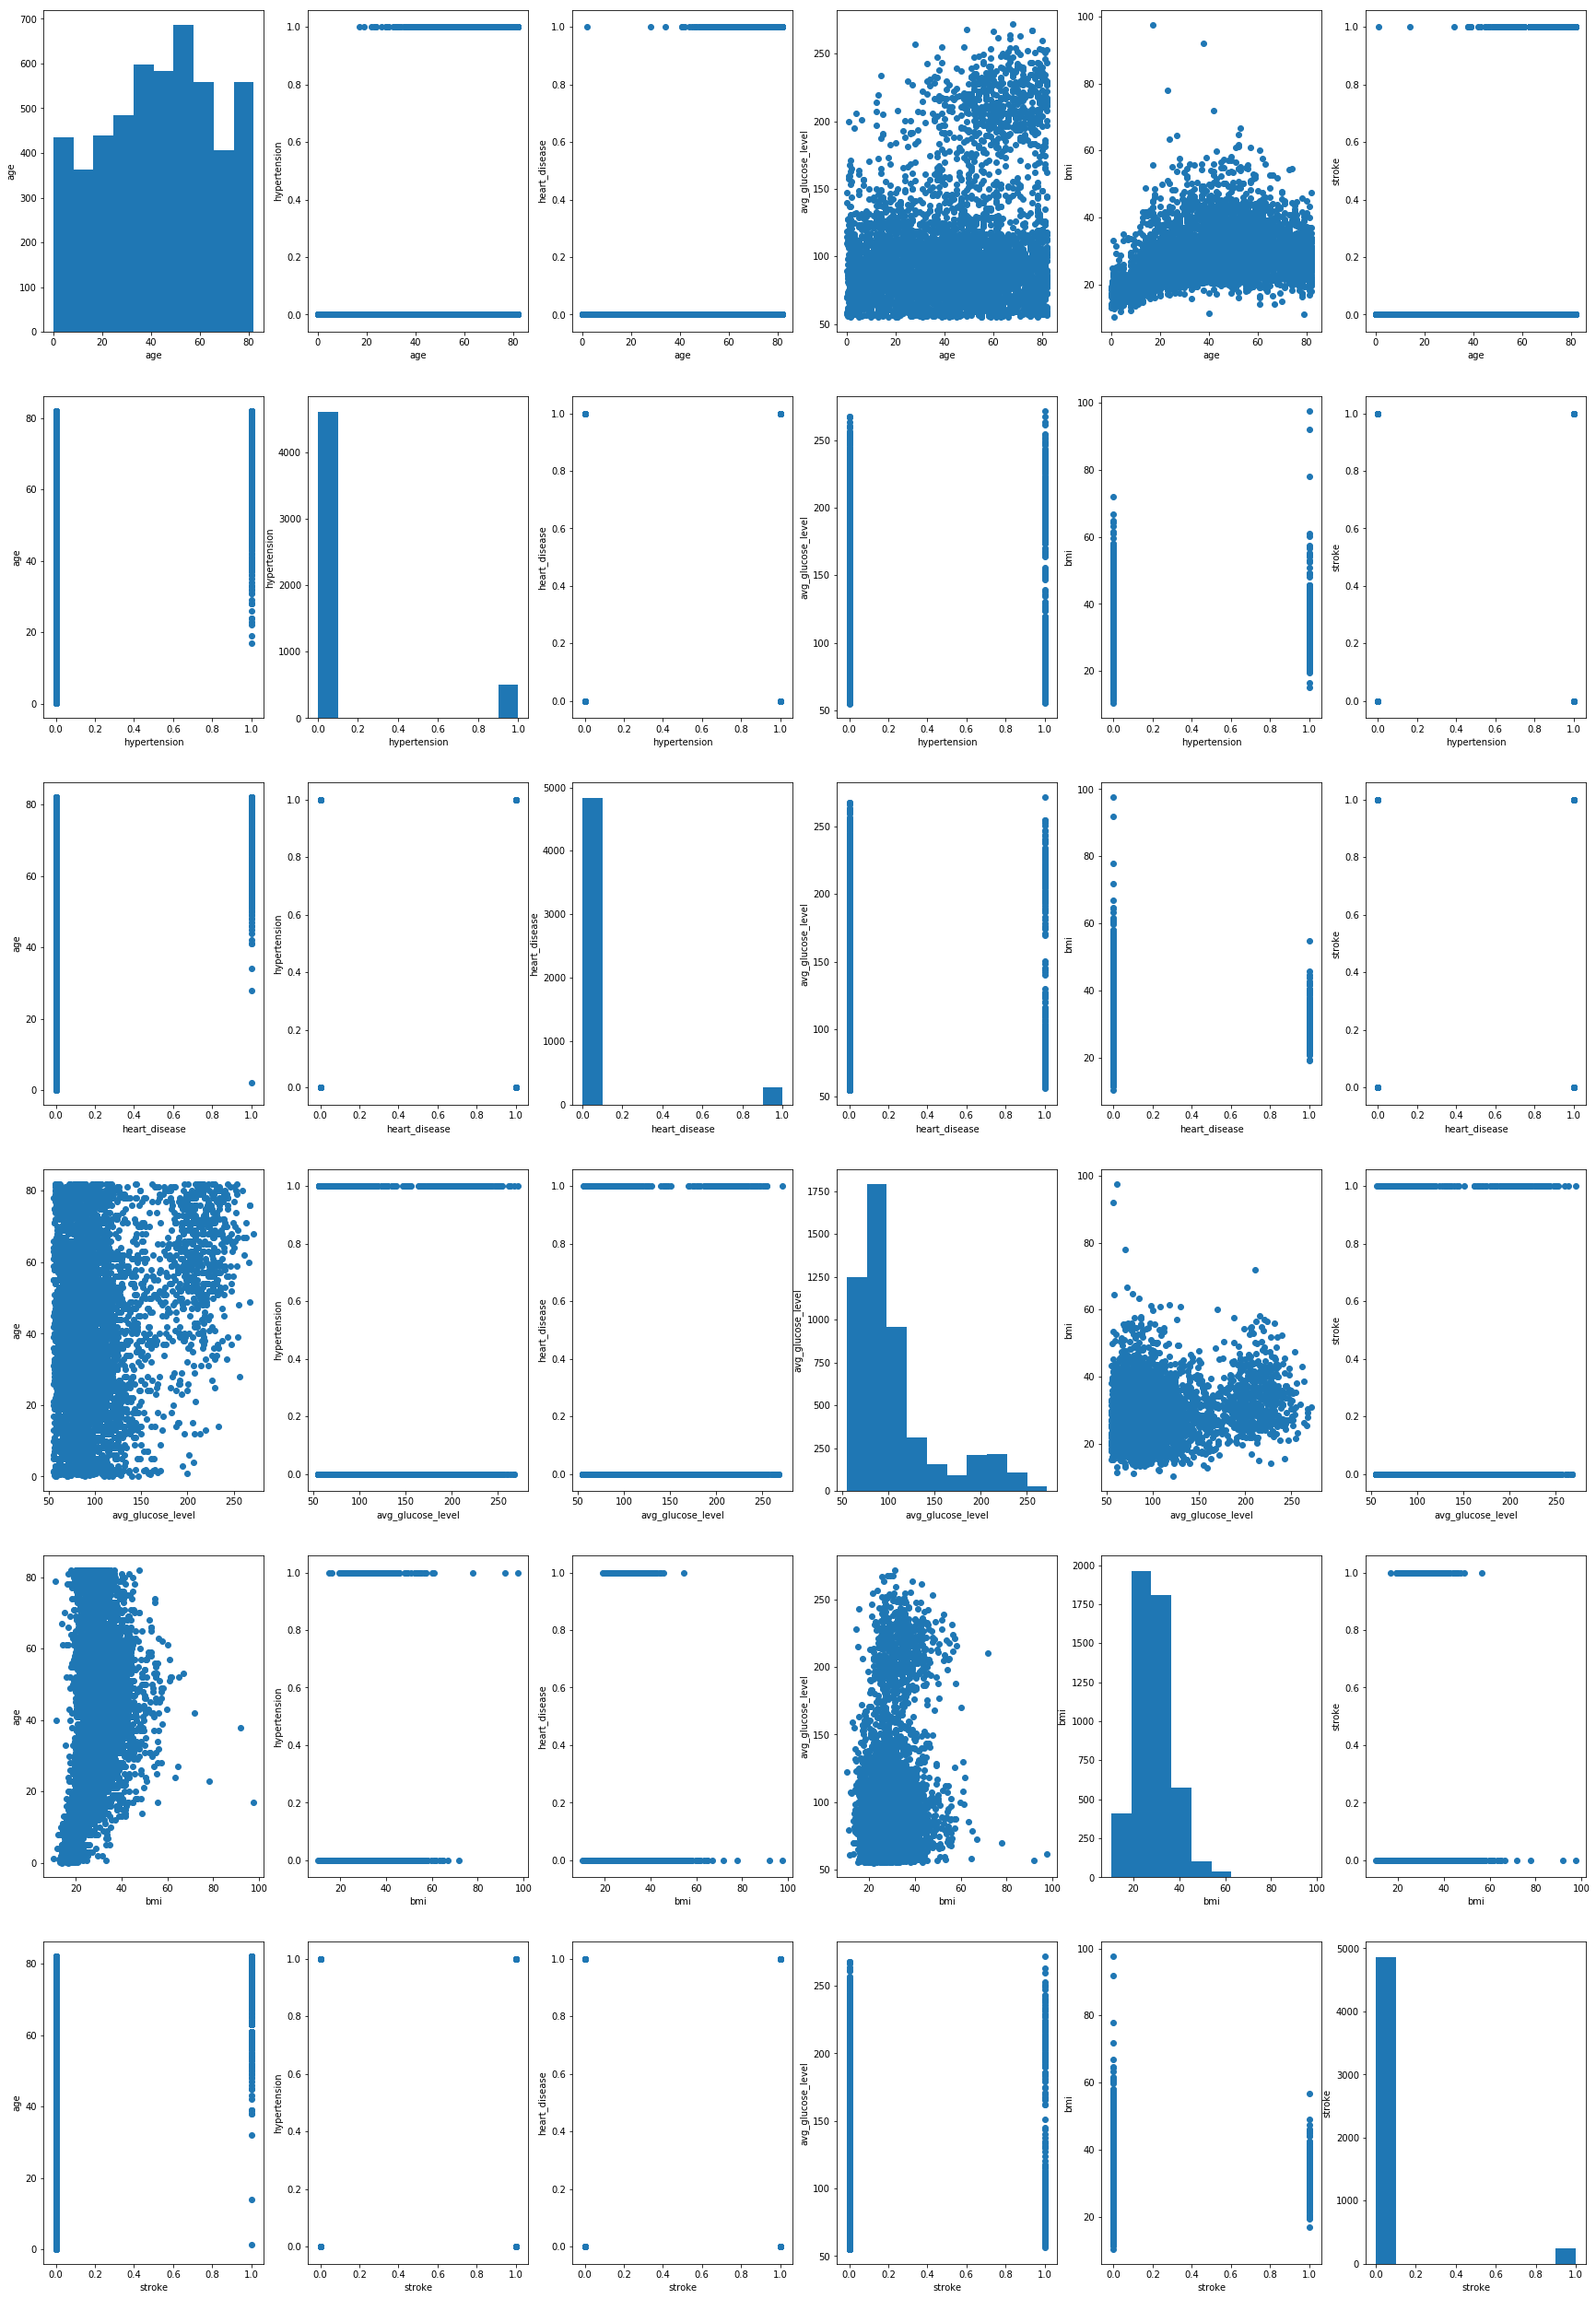

In [22]:
# Visualization - 2.3 - Pairplot

import matplotlib.pyplot as plt

# These are the columns that encoded using numerics.
colThatneedsPlot = ["age", "hypertension", "heart_disease", "avg_glucose_level", "bmi", "stroke"]

fig, axs = plt.subplots(len(colThatneedsPlot), len(colThatneedsPlot), figsize=(30, 45))

for index1, col1 in enumerate(colThatneedsPlot):
    for index2, col2 in enumerate(colThatneedsPlot):
        if(index1 == index2):
            axs[index1, index2].hist(org_frame[col1].dropna())
        else:
            axs[index1, index2].scatter(org_frame[col1], org_frame[col2])
        axs[index1, index2].set(xlabel= col1, ylabel= col2)

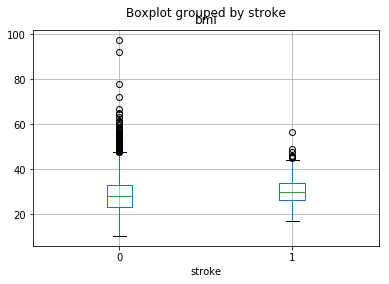

In [6]:
# Visualization - 2.3 - Boxplot
org_frame.boxplot(column=['bmi'], by = "stroke")

In [7]:
# Encode Labels with numbers, to produce heatmap

# encode ever married
for index, value in enumerate(org_frame['ever_married'].unique()):
    org_frame['ever_married'] = org_frame['ever_married'].replace(value,index)
    
# encode gender
for index, value in enumerate(org_frame['gender'].unique()):
    org_frame['gender'] = org_frame['gender'].replace(value,index)
    
# encode work_type
for index, value in enumerate(org_frame['work_type'].unique()):
    org_frame['work_type'] = org_frame['work_type'].replace(value,index)
    
# encode Residence_type
for index, value in enumerate(org_frame['Residence_type'].unique()):
    org_frame['Residence_type'] = org_frame['Residence_type'].replace(value,index)
    
# encode smoking_status
for index, value in enumerate(org_frame['smoking_status'].unique()):
    org_frame['smoking_status'] = org_frame['smoking_status'].replace(value,index)


In [8]:
# Visualization - 2.3 - Heatmap

corrRes = org_frame.corr()
corrRes.style.background_gradient(cmap ='coolwarm')

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,1,-0.00140592,0.00353807,0.00354961,-0.00129594,-0.0136896,-0.0180295,0.00140306,0.00109236,0.003084,-0.018551,0.00638817
gender,-0.00140592,1,0.0273001,-0.0213901,-0.0857492,-0.0293658,-0.0662116,-0.00552872,-0.0542134,0.0256577,-0.0396932,-0.0092003
age,0.00353807,0.0273001,1,0.276398,0.263796,-0.679125,-0.41327,-0.01418,0.238171,0.333398,-0.375845,0.245257
hypertension,0.00354961,-0.0213901,0.276398,1,0.108306,-0.164243,-0.0750967,0.00791345,0.174474,0.167811,-0.129012,0.127904
heart_disease,-0.00129594,-0.0857492,0.263796,0.108306,1,-0.114644,-0.0582628,-0.00309202,0.161857,0.0413574,-0.0646712,0.134914
ever_married,-0.0136896,-0.0293658,-0.679125,-0.164243,-0.114644,1,0.375944,0.00626095,-0.155068,-0.341695,0.303694,-0.10834
work_type,-0.0180295,-0.0662116,-0.41327,-0.0750967,-0.0582628,0.375944,1,-0.0145727,-0.0681351,-0.347241,0.307774,-0.0582241
Residence_type,0.00140306,-0.00552872,-0.01418,0.00791345,-0.00309202,0.00626095,-0.0145727,1,0.00494565,0.000122441,-0.00465598,-0.015458
avg_glucose_level,0.00109236,-0.0542134,0.238171,0.174474,0.161857,-0.155068,-0.0681351,0.00494565,1,0.175502,-0.0977322,0.131945
bmi,0.003084,0.0256577,0.333398,0.167811,0.0413574,-0.341695,-0.347241,0.000122441,0.175502,1,-0.23574,0.0423737


In [9]:
############################# 2.4 Data Quality - Missing Values

In [10]:
#Initialization the pyspark envionment, it will be named Assignment_722 and used for the assignment.
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Assignment_722").getOrCreate()

In [11]:
#Load csv file into spark and evaluate the status of it.
dataF = spark.read.load("./stoke_dataset.csv", format = "csv", header = "true")
dataF.printSchema()
dataF.columns

root
 |-- id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- hypertension: string (nullable = true)
 |-- heart_disease: string (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: string (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: string (nullable = true)



['id',
 'gender',
 'age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'avg_glucose_level',
 'bmi',
 'smoking_status',
 'stroke']

In [12]:
#Check possible output for categories for possible missing values
dataF.select("gender").distinct().show() #Female, Male, Other
dataF.select("hypertension").distinct().show() # 0 = No, 1 = Yes
dataF.select("heart_disease").distinct().show() # 0 = No, 1 = Yes
dataF.select("ever_married").distinct().show() # No = No, Yes = Yes
dataF.select("work_type").distinct().show() # Never Worked, Self-employed, Private, Children, Govt_job
dataF.select("Residence_type").distinct().show() # Urban, Rural
dataF.select("smoking_status").distinct().show() # Smoke, Unknown, Never smoked, Formely smoked
dataF.select("stroke").distinct().show() # 0 = No, 1 = Yes

#Out of these values, the smoking status is containning missing value as it contain 'Unknown'
dataF.where(dataF.smoking_status == "Unknown").select("*").count() # 1544 Missing Value

+------+
|gender|
+------+
|Female|
| Other|
|  Male|
+------+

+------------+
|hypertension|
+------------+
|           0|
|           1|
+------------+

+-------------+
|heart_disease|
+-------------+
|            0|
|            1|
+-------------+

+------------+
|ever_married|
+------------+
|          No|
|         Yes|
+------------+

+-------------+
|    work_type|
+-------------+
| Never_worked|
|Self-employed|
|      Private|
|     children|
|     Govt_job|
+-------------+

+--------------+
|Residence_type|
+--------------+
|         Urban|
|         Rural|
+--------------+

+---------------+
| smoking_status|
+---------------+
|         smokes|
|        Unknown|
|   never smoked|
|formerly smoked|
+---------------+

+------+
|stroke|
+------+
|     0|
|     1|
+------+



1544

In [13]:
#Check continues variable's missing value
dataF.filter("age is null or age == 'N/A'").count() #0

0

In [14]:
dataF.filter("bmi is null or bmi == 'N/A'").count() #201

201

In [15]:
dataF.filter("avg_glucose_level is null or avg_glucose_level == 'N/A'").count() #0

0

In [16]:
############################# 2.4 Data Quality - Outlier and Extreme Values
from pyspark.sql.functions import col
from pyspark.sql.types import (StructField,DoubleType)

dataF = dataF.withColumn("bmi",col("bmi").cast(DoubleType())) \
    .withColumn("age",col("age").cast(DoubleType())) \
    .withColumn("avg_glucose_level",col("avg_glucose_level").cast(DoubleType()))
dataF.printSchema()


root
 |-- id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: string (nullable = true)
 |-- heart_disease: string (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: string (nullable = true)



In [17]:
elementsToCheck = "age"

quantiles = dataF.stat.approxQuantile(elementsToCheck, [0.25,0.75],0.0)
IQR = quantiles[1] - quantiles[0]

LowerRange = quantiles[0] - 1.5 * IQR
UpperRange = quantiles[1] + 1.5 * IQR

query = elementsToCheck + " < " + str(LowerRange) + " or " + elementsToCheck + " >" + str(UpperRange)
print(query)

dataF.filter(query).count() #0

age < -29.0 or age >115.0


0

In [18]:
elementsToCheck = "bmi" 

quantiles = dataF.stat.approxQuantile(elementsToCheck, [0.25,0.75],0.0)
IQR = quantiles[1] - quantiles[0]

LowerRange = quantiles[0] - 1.5 * IQR
UpperRange = quantiles[1] + 1.5 * IQR

query = elementsToCheck + " < " + str(LowerRange) + " or " + elementsToCheck + " >" + str(UpperRange)
print(query)

dataF.filter(query).count() #110

bmi < 9.099999999999998 or bmi >47.5


110

In [19]:
elementsToCheck = "avg_glucose_level" #625

quantiles = dataF.stat.approxQuantile(elementsToCheck, [0.25,0.75],0.0)
IQR = quantiles[1] - quantiles[0]

LowerRange = quantiles[0] - 1.5 * IQR
UpperRange = quantiles[1] + 1.5 * IQR

query = elementsToCheck + " < " + str(LowerRange) + " or " + elementsToCheck + " > " + str(UpperRange)
print(query)

dataF.filter(query).count() #625

avg_glucose_level < 21.910000000000018 or avg_glucose_level > 169.51


625